In [1]:
##Model

import torch
import torch.nn as nn
import numpy as np


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool3d(kernel_size=2, stride=2)]
        elif v== 'A':
            layers += [nn.AvgPool3d(kernel_size=2, stride=2)]
        else:
            conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv3d, nn.BatchNorm3d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv3d, nn.ReLU(inplace=True)]
            in_channels = v
    layers += [nn.AdaptiveAvgPool3d((1, 1, 1))]
    return nn.Sequential(*layers)


class VGG3D(nn.Module):

    def __init__(self, features, init_weights=False):
        super(VGG3D, self).__init__()
        self.features = features
    # def __init__(self, init_weights=False):
    #     super(VGG3D, self).__init__()
    #     self.features = nn.Sequential(
    #         nn.Conv3d(1,32, 5, padding=1),
    #         nn.BatchNorm3d(32),
    #         nn.LeakyReLU(0.1, inplace=True),
    #         nn.MaxPool3d(5, 5),
    #         nn.Conv3d(32, 64, 5, padding=1),
    #         nn.BatchNorm3d(64),
    #         nn.LeakyReLU(0.1, inplace=True),
    #         nn.MaxPool3d(5, 5),
    #         nn.Conv3d(64, 128, 3, padding=1),
    #         nn.BatchNorm3d(128),
    #         nn.LeakyReLU(0.1, inplace=True),
    #         nn.MaxPool3d(2, 2)
    #     )
        self.regressor1 = nn.Sequential(
            nn.Linear(256, 64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(64, 1),
            # nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )
        self.regressor2 = nn.Sequential(
            nn.Linear(2, 1)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x, maxflow):
        device = x.device
        x = self.features(x)  # Through the layers
        x = torch.flatten(x, start_dim=1)

        x = self.regressor1(x)
        x = torch.cat((x, maxflow.unsqueeze(1)), dim=1)
        x = self.regressor2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [2]:
##DATASET

import os
import numpy as np
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, img_path, perms, list_IDs, maxflow):
        'Initialization'
        self.img_path = img_path
        self.perms = perms
        self.list_IDs = list_IDs
        self.maxflow = maxflow

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Get one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        
        img = np.fromfile(os.path.join(self.img_path, f'{ID:06d}.raw'), np.uint8).reshape(100, 100, 100)
        img = np.expand_dims(img, axis=0)
        perm = np.log(self.perms[index] / 9.869233e-16)
        perm = np.expand_dims(perm, axis=-1)
        maxflow = self.maxflow[index]

        return img, perm, maxflow # We return permeability in normalised mD (SO WE ARE TRAINING ON LN(K mD))

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import tqdm
from tqdm import tqdm
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)

# hyper-parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
print (f"Let's use {device}")

n_channels = 1
n_epochs = 50
lr = 10e-4
batch_size = 8
num_samples = 2000


# dataloader
base_dir = r"E:\Oleg\Stanford samples raw x100"
data_dir = base_dir
data_path = "E:\Oleg\Data_binary.xlsx"
true_data = pd.read_excel(data_path, header=0)
df = true_data.head(num_samples)

IDs = np.array(df.ID.astype(np.int32))
perms = np.array(df.Permeability)
maxflows = np.array(df.maxflow)
idx = perms > 1e-20
perms = perms[idx]
IDs = IDs[idx]
maxflows = maxflows[idx]

idx = np.random.permutation(len(IDs))
perms = perms[idx]
IDs = IDs[idx]
maxflows = maxflows[idx]

val_ratio = 0.1
val_num = int(len(idx) * val_ratio)
perms_train = perms[val_num:]
IDs_train = IDs[val_num:]
maxflows_train = maxflows[val_num:]

perms_val = perms[:val_num]
IDs_val = IDs[:val_num]
maxflows_val = maxflows[:val_num]

train_dataset = MyDataset(data_dir, perms_train, IDs_train, maxflows_train)
valid_dataset = MyDataset(data_dir, perms_val, IDs_val, maxflows_val)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# model
cfg = [8, 8, 'M', 16, 16, 'M', 32, 32, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256]
model = VGG3D(make_layers(cfg, batch_norm=True))

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)
model_dir = os.path.join(base_dir, 'saved_models', 'sandstone')
os.makedirs(model_dir, exist_ok=True)

real_result = []
predicted_result = []

# training
criterior = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_loss_history = np.zeros(n_epochs)
valid_loss_history = np.zeros(n_epochs)

True
Let's use cuda
Let's use 2 GPUs!


Epoch 0: 225it [01:03,  3.55it/s]


epoch: 0 | training loss: 0.5909 | validation loss: 0.0312
R2 train: -3.9616 | R2 val: 0.6927


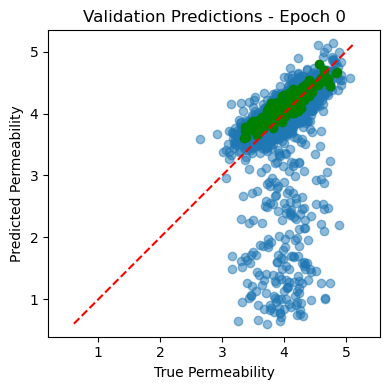

Epoch 1: 225it [01:04,  3.51it/s]


epoch: 1 | training loss: 0.0295 | validation loss: 0.0145
R2 train: 0.7521 | R2 val: 0.8570


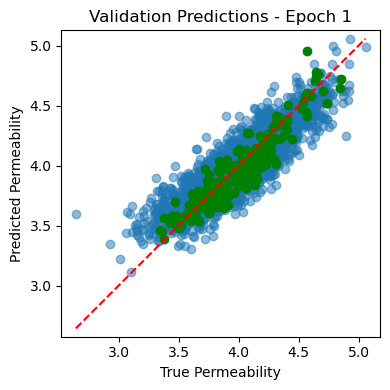

Epoch 2: 225it [01:03,  3.56it/s]


epoch: 2 | training loss: 0.0284 | validation loss: 0.0487
R2 train: 0.7617 | R2 val: 0.5204


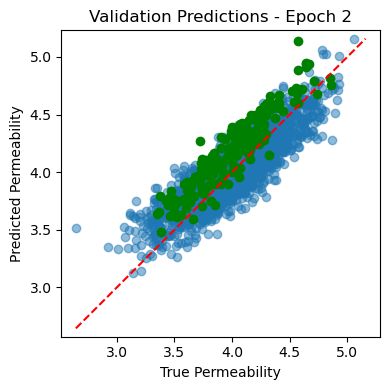

Epoch 3: 225it [01:01,  3.67it/s]


KeyboardInterrupt: 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

kernel_size = 2
avg_pool3d = nn.AvgPool3d(kernel_size=kernel_size, stride=kernel_size)

for epoch in range(n_epochs):
    train_loss = 0
    model.train()
    all_true_train = []
    all_pred_train = []
    all_true_val = []
    all_pred_val = []

    for i, (img, true_perm, maxflow) in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch}'):
        img = img.to(device, dtype=torch.float)
        # img = avg_pool3d(img)
        true_perm = true_perm.to(device, dtype=torch.float)
        maxflow = maxflow.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred_perm = model(img, maxflow)
        loss = criterior(pred_perm, true_perm)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        all_true_train.append(true_perm.detach().cpu().numpy().flatten())
        all_pred_train.append(pred_perm.detach().cpu().numpy().flatten())

    # Validation loop
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for img, true_perm, maxflow in valid_dataloader:
            img = img.to(device, dtype=torch.float)
            # img = avg_pool3d(img)
            true_perm = true_perm.to(device, dtype=torch.float)
            maxflow = maxflow.to(device, dtype=torch.float)

            pred_perm = model(img, maxflow)
            loss = criterior(pred_perm, true_perm)
            valid_loss += loss.item()

            all_true_val.append(true_perm.detach().cpu().numpy().flatten())
            all_pred_val.append(pred_perm.detach().cpu().numpy().flatten())
    
    # Store losses
    train_loss_history[epoch] = train_loss / len(train_dataloader)
    valid_loss_history[epoch] = valid_loss / len(valid_dataloader)
    
    print(f'epoch: {epoch} | training loss: {train_loss_history[epoch]:.4f} | validation loss: {valid_loss_history[epoch]:.4f}')
    print(f'R2 train: {r2_score(np.concatenate(all_true_train), np.concatenate(all_pred_train)):.4f} | R2 val: {r2_score(np.concatenate(all_true_val), np.concatenate(all_pred_val)):.4f}')
    scheduler.step()

    # Save model and losses
    torch.save(model.state_dict(), os.path.join(model_dir, f'model_{epoch}.pth'))
    np.save(os.path.join(model_dir, 'train_loss_history.npy'), train_loss_history)
    np.save(os.path.join(model_dir, 'valid_loss_history.npy'), valid_loss_history)

    all_true_train = np.concatenate(all_true_train)
    all_pred_train = np.concatenate(all_pred_train)
    all_true_val = np.concatenate(all_true_val)
    all_pred_val = np.concatenate(all_pred_val)

    # Scatter plot of predictions vs. true
    plt.figure(figsize=(4, 4))
    plt.scatter(all_true_train, all_pred_train, alpha=0.5)
    plt.scatter(all_true_val, all_pred_val, color='g')
    min_val = min(np.min(all_true_train), np.min(all_pred_train))
    max_val = max(np.max(all_true_train), np.max(all_pred_train))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # y=x reference line
    plt.xlabel("True Permeability")
    plt.ylabel("Predicted Permeability")
    plt.title(f"Validation Predictions - Epoch {epoch}")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    plt.close()

print('done')


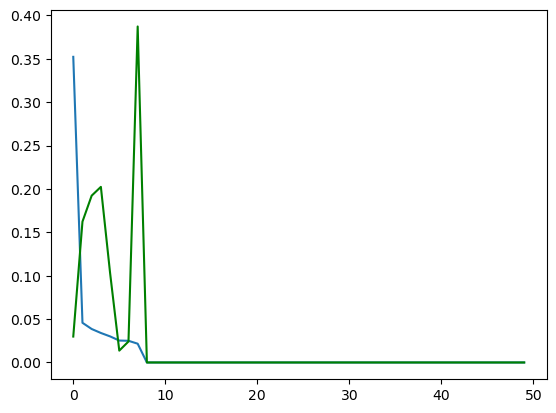

In [ ]:
import matplotlib.pyplot as plt

epochs = range(n_epochs)
plt.plot(epochs, train_loss_history)
plt.plot(epochs, valid_loss_history, color='g')

In [ ]:
real_result = []
predicted_result = []
maxflow_res = []

# model.load_state_dict(torch.load("E:\Oleg\Новая папка\PermNet\saved_models\sandstone\model_2.pth"))
length = 100
for i in range(300, 500):
    img = np.fromfile(os.path.join(data_dir, f"{true_data.loc[i, 'ID']:06d}.raw"), np.uint8).reshape(200, 200, 200)
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)  # Shape: (1, 1, 200, 200, 200)

    perm = true_data.loc[i, 'Permeability']
    maxflow = true_data.loc[i, 'maxflow']

    real_result.append(perm)
    maxflow_res.append(maxflow)
  
    img = torch.tensor(img, device=device, dtype=torch.float)
    img = avg_pool3d(img)
    maxflow_tensor = torch.tensor([maxflow], device=device, dtype=torch.float)

    pred_perm = model(img, maxflow_tensor)  # Output tensor on device

    pred_perm_exp = torch.exp(pred_perm) * 9.869233e-16

    predicted_result.append(pred_perm_exp.item())  # safely convert to Python float



ValueError: cannot reshape array of size 1000000 into shape (200,200,200)

In [ ]:
data = pd.DataFrame({'real' : real_result, 'predict' : predicted_result, 'maxflow' : maxflow_res})
data.real *= 1.0e+14
data.predict *= 1.0e+14

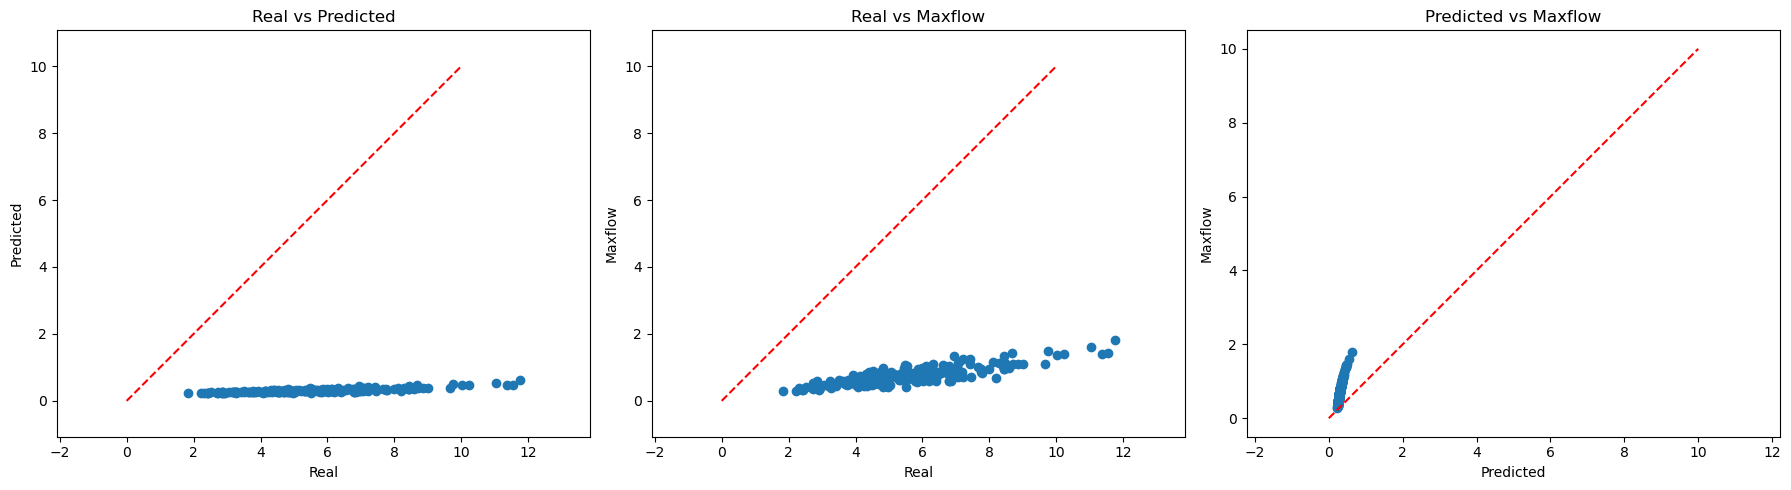

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Real vs Predicted
axs[0].scatter(data.real, data.predict)
axs[0].plot([0, 10], [0, 10], 'r--')  # identity line
axs[0].set_title('Real vs Predicted')
axs[0].set_xlabel('Real')
axs[0].set_ylabel('Predicted')
axs[0].axis('equal')

# 2. Real vs Maxflow
axs[1].scatter(data.real, data.maxflow)
axs[1].plot([0, 10], [0, 10], 'r--')
axs[1].set_title('Real vs Maxflow')
axs[1].set_xlabel('Real')
axs[1].set_ylabel('Maxflow')
axs[1].axis('equal')

# 3. Predicted vs Maxflow
axs[2].scatter(data.predict, data.maxflow)
axs[2].plot([0, 10], [0, 10], 'r--')
axs[2].set_title('Predicted vs Maxflow')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Maxflow')
axs[2].axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(data, true_col='y_true', pred_col='y_pred'):
    y_true = data[true_col].values
    y_pred = data[pred_col].values
    
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'Mean Error': np.mean(y_pred - y_true),
        'Correlation': np.corrcoef(y_true, y_pred)[0, 1]
    }
    
    return pd.Series(metrics)

print(regression_metrics(data, 'real', 'predict'))


MAE             5.218851
MSE            30.679445
RMSE            5.538903
R²             -7.463012
Mean Error     -5.218851
Correlation     0.827798
dtype: float64


In [ ]:
df = pd.DataFrame({'real':real_result, 'predicted':predicted_result})
df.head()
save_path = r"E:\Oleg\result_maxflow_bin_" + str(len) + ".xlsx"
df.to_excel(save_path)

OSError: [Errno 22] Invalid argument: 'E:\\Oleg\\result_maxflow_bin_<built-in function len>.xlsx'

In [ ]:
plt.hist(true_data.Permeability[true_data.Permeability < 0.1e-12])